# 2.4 scipy

# 1 overview
1. SciPy builds on top of NumPy to provide common tools for scientific programming(**PI:,**) such as
   - linear algebra
   - numerical integration
   - interpolation
   - optimization
   - distributions and random number generation
   - signal processing
   - etc.
2. Like NumPy, SciPy is stable, mature and widely used.
   - Many SciPy routines are thin wrapper around industry-standard Fortran libraries(**PI:,**) such as LAPACK, BLAS, (**PI1: links should be attached?**) etc.
   - It's not really necessary to "learn" SciPy as a whole, but we should get some idea of what's in the library and then look up [documentation](https://docs.scipy.org/doc/scipy/reference/index.html) as required.
     - We aim only to highlight some useful parts of the package in this lecture.

# 2 scipy vs numpy

1. SciPy is a package that contains various tools that are built on top of NumPy, using its array data type and related functionality.
   - In fact, when we import SciPy(**PI:,**) we also get NumPy, as can be seen from this excerpt the SciPy initialization file (**PI2: problem with it?**), see Program 1.
   - However, it's more common and better practice to use NumPy functionality explicitly, see Program 2.
2. What is useful in SciPy is the **functionality in its sub-packages**.
   - e.g.
     - `scipy.optimize`, 
     - `scipy.integrate`, 
     - `scipy.stats`, etc.
   - We explore some of the major sub-packages in this section.

In [1]:
# Program 1: import numpy symbols to scipy namespace

from numpy import *
from numpy.random import rand, randn
from numpy.fft import fft, ifft
from numpy.lib.scimath import *

In [2]:
# Program 2

import numpy as np

a = np.identity(3)

# 3 statistics

1. The `scipy.stats` subpackage supplies:
   - numerous **random variable objects**,
     - such as densities, cumulative distributions, random sampling, etc.
   - some estimation procedures,
   - some statistical tests.
   
## 3.1 random variables and distributions
1. Recall that `numpy.random` provides functions for **generating random variables**, see Program 1.
   - This generates a draw from the distribution (**PI3: with the density function**)below when $a, b = 5,5$ (**PI4:? from ` ` to dollar signs**)
     $$
     f(x; a, b) = \frac{x^{a-1} (1-x)^{b-1} }{ \int^1_0 u^{(a-1)} (1-u)^{(b-1)} du }  (0 \leq x \leq 1)
     $$
2. Sometimes(**PI:,**) we need access to the density itself, or the cdf, the quantities, etc.
   - For this, we can use `scipy.stats`, which provides all of this functionality as well as random number generation in a single consistent interface.
     - e.g., see Program 2.
       - The object `q` that represents the distribution has **additional useful methods**, including cdf, ppf and mean, see Program 3-5.
   - The general syntax for creating these objects that represent distributions (of type `rv_frozen`) is 
   
     `name = scipy.stats.distribution_name(shape_parameters, loc=c, scale=d)`
   
      - Here(**PI:,**) `distribution_name` is one of the distribution names in scipy.stats.
      - The `loc` and `scale` parameters transform the original random variable $X$ into $Y=c + d X$.


In [3]:
# Program 1

np.random.beta(5, 5, size=3)

array([0.54065311, 0.5826938 , 0.48673274])

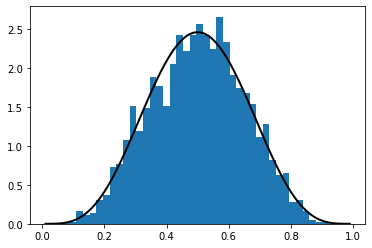

In [4]:
# Program 2

from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

q = beta(5, 5)                         # Beta(a, b), with a = b = 5
obs = q.rvs(2000)      


# 2000 observations
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, density=True)
ax.plot(grid, q.pdf(grid), 'k-', linewidth=2)
plt.show()

In [5]:
# Program 3: cumulative distribution function

q.cdf(0.4)

0.26656768000000003

In [10]:
# Program 4: quantile (inverse cdf) function

q.ppf(0.8)

0.6339134834642708

In [11]:
# Program 5: mean

q.mean()

0.5

## 3.2 alternative syntax

1. There is an alternative way of calling the methods described above.
   - e.g., the code that generates the figure above can be replaced by the Program 6.

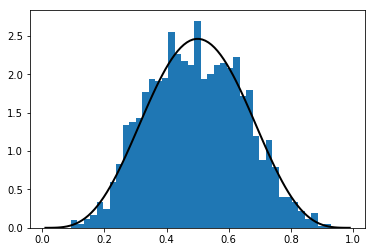

In [13]:
# Program 6

obs = beta.rvs(5, 5, size=2000) # Use the methods directly? PI5: not a big difference?
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, density=True)
ax.plot(grid, beta.pdf(grid, 5, 5), 'k-', linewidth=2)
plt.show()

## 3.3 other goodies in scipy.stats
1. There are a variety (**PI6: of**) **statistical functions** in `scipy.stats`.
   - e.g., `scipy.stats.linregress` implements simple linear regression, see Program 7.
   - To see the full list, see the [documentation](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions-scipy-stats).

In [15]:
# Program 7

from scipy.stats import linregress

x = np.random.randn(200)
y = 2 * x + 0.1 * np.random.randn(200) # Why this setting?

gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

(2.0021555234517954, -0.0018780451963003597)

# 4 roots and fixed points

1. A **root** or **zero** of a real function $f$ on $[a,b]$ is an $x \in [a, b]$ such that $f(x)=0$.
   - e.g., if we plot the function 
   $$f(x) = \sin (4(x - \frac{1}{4})) + x + x^{20} - 1 \tag{2}
   $$ 
   with $x \in [0, 1] $, then we can see Program 1.
     - The unique root is approximately $0.408$.
   - Let's consider some numerical techniques for finding roots, see 4.1-4.5.

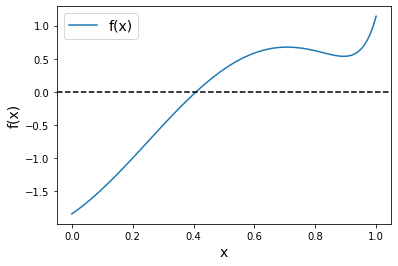

In [13]:
# Program 1: PI7: add labels or legend?

f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, f(x), label='f(x)')
ax.axhline(ls='--', c='k')
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('f(x)', fontsize=14)
ax.legend(fontsize=14)
plt.show()

## 4.1 bisection
1. One of the most common algorithms for numerical root-finding is **bisection**.
   - To understand the idea, recall the well-known game where
     - Player A thinks of a secret number between $1$ and $100$,
     - Player B asks if it's less than $50$
       - If yes, B asks if it's less than $25$.
       - If no, B asks if it's less than $75$.
         - And so on.
   - This is bisection (**PI8: a [link](https://en.wikipedia.org/wiki/Bisection_method)?**)
   - Here's a simplistic implementation of the algorithm in Python, see Program 2.
     - It works for all sufficiently well(**PI: -**)behaved increasing continous functions with $f(a)< 0 < f(b)$(**PI: .**)
     - Let's test it using the function $f$ defined in (2), see Program 3.
   - Not surprisingly, **SciPy** provides its own bisection function.
     - Let's test it using the same function $f$ defined in (2), see Program 4.

In [12]:
# Program 2

def bisect(f, a, b, tol=10e-5):
    
    lower, upper = a, b
    
    while upper - lower > tol:
        middle = 0.5 * (upper + lower)
        if f(middle) > 0:  # PI: why not `if f(lower) * f(middle)< 0:`
            lower, upper = lower, middle
        else:
            lower, upper = middle, upper
    return 0.5 * (upper + lower)

In [19]:
# Program 3

bisect(f, 0, 1)

0.4082935042806639

In [17]:
# Program 4

from scipy.optimize import bisect

bisect(f, 0, 1)

0.4082935042806639

## 4.2 the Newton-Raphson method
1. Another very common root-finding algorithm is the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method).
   - In SciPy(**PI:,**) this algorithm is implemented by `scipy.optimize.newton`.
2. Bisection V.S. Newton-Raphson: unlike bisection, the Newton-Raphson method uses **local slope information** in an attempt to increase the speed of convergence.
   - Let's investigate this using the same function $f$ defined in (2).
     - With a suitable initial condition for the search(**PI:,**) we get convergence, see Program 5.
     - But other initial conditions lead to failure of convergence, see Program 6 (**PI: ?**).

In [28]:
# Program 5

from scipy.optimize import newton

newton(f, 0.2) # Start the search at initial condition x = 0.2

0.40829350427935673

In [29]:
# Program 6

newton(f, 0.7)  # Start the search at x = 0.7 instead

0.7001700000000279

## 4.3 hybrid methods

1. A general principle of numerical methods is as follows:
   - If we have specific knowledge about a given problem, then we might be able to exploit it to generate efficiency.
   - If not, then the choice of (**PI: the**) algorithm involves a trade-off between **speed** and **robustness**.
2. In practice, most default algorithms for **root-finding**, **optimization** and **fixed points** use **hybrid** methods.
   - These methods typically combine a **fast method** with a **robust method** in the following manner:
     - Attempt to use a fast method,
     - Check diagnostics (**???**),
     - If diagnostics are bad, then switch to a more robust algorithm.
   - e.g., in `scipy.optimize`, the function `brentq` is such a hybrid method and(**PI: with?**) a good default, see Program 7.
     - Here(**PI:,**) the correct solution is found and the speed is better than bisection, see Program 8-9.

In [32]:
# Program 7

import scipy as sp
from scipy.optimize import brentq

brentq(f, 0, 1)
sp.optimize.brentq(f, 0, 1) # PI9: replace `brentq` with `sp.optimize.brentq`

0.40829350427936706

In [35]:
# Program 8-1: hybrid

%timeit brentq(f, 0, 1)

16.8 µs ± 263 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
# Program 8-2: hybrid

%timeit sp.optimize.brentq(f, 0, 1)

16.9 µs ± 449 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [34]:
# Program 9: bisection

%timeit bisect(f, 0, 1)

60.5 µs ± 320 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## 4.4 multivariate root-finding
1. Use `scipy.optimize.fsolve`, a wrapper for a hybrid method in MINPACK (**PI10: MINPACK?**).
   - See the [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html] (**PI11: a possible example of it**).

## 4.5 fixed points

1. A **fixed point** of a real function $f$ on $[a,b]$ is an $x \in [a, b]$ such that $f(x)=x$.
   - SciPy has a function for finding (scalar) fixed points(**PI: ,**) too(**PI: ,**) see Program 10.
   - If we don't get good results, then we can always switch back to the `brentq` root finder, since the fixed point of a function $f$ is the root of $g(x) = x - f(x)$.

In [44]:
# Program 10

from scipy.optimize import fixed_point # PI12: Why this, not `import scipy as sp`?

fixed_point(lambda x: x**2, 10.0) # 10.0 is an initial guess; failed if the initial is smaller than -1

array(1.)

# 5 optimization

1. Most numerical packages provide only functions for minimization.
   - Maximization can be performed by recalling that the maximizer of a function $f$ on domain $D$ is the minimizer of $-f$ on $D$.
   - Minimization is closely related to root-finding:
     - For smooth functions, interior optima correspond to roots of the first derivative.
2. The speed/robustness trade-off described above is present(**PI:ed**) with numerical optimization(**PI:,**) too.
   - Unless we have some prior information we can exploit, it's usually best to use hybrid methods.
   - For constrained (**PI:?**), univariate (i.e., scalar) minimization, a good hybrid option is `fminbound`, see Program 1.


In [45]:
from scipy.optimize import fminbound

fminbound(lambda x: x**2, -1, 2)

0.0

## 5.1 multivariate optimization
1. Multivariate local optimizers (**?**) include `minimize`, `fmin`, `fmin_powell`, `fmin_cg`, `fmin_bfgs`, and `fmin_ncg`.
2. Constrained multivariate local optimizers include `fmin_l_bfgs_b`, `fmin_tnc`, `fmin_cobyla`.
3. See [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html#local-multivariate-optimization).

# 6 integration

1. Most numerical integration methods work by computing the integral of an approximating polynomial.
   - The **resulting error** depends on how well the polynomial fits the integrand, which in turn depends on how "regular" the integrand is.
2. In SciPy, the relevant module for numerical integration is `scipy.integrate`.
   - A good default for univariate integration is `quad`, see Program 1.
     - In fact, `quad` is an interface to a very standard numerical integration routine in the Fortran library QUADPACK.
     - It uses [Clenshaw-Curtis quadrature](https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature), based on expansion in terms of Chebychev polynomials.
   - There are other options for univariate integration.
     - A useful one is `fixed_quad`, which is fast and hence works well inside `for` loops. (**?**)
   - There are also functions for multivariate integration (**?**).
     - See [documentation](https://docs.scipy.org/doc/scipy/reference/integrate.html).

In [48]:
# Program 1

from scipy.integrate import quad

integral, error = quad(lambda x: x**2, 0, 1)
print(integral, error) # PI13: add print()

0.33333333333333337 3.700743415417189e-15


# 7 linear algebra

1. We saw that **NumPy** provides a module for linear algebra called `linalg`. (**PI14: a link might be better?**)
2. **SciPy** also provides a module for linear algebra with the same name.
   - This one is not an exact superset of the former, but overall it has more functionality.
   - We can investigate this [module](https://docs.scipy.org/doc/scipy/reference/linalg.html).

# 8 exercises

## Exercise 1

Previously we discussed the concept of [recursive function calls](https://python.quantecon.org/python_advanced_features.html#recursive-functions). (PI15: we don't discuss it before this lecture, so it might not be so appropriate.)

Try to write a recursive implementation of homemade bisection function [described above](#bisect-func). (PI16: more discussions on the recursive implementation and the task)

Test it on the function [(2)](#equation-root-f).

In [71]:
def bisect(f, a, b, tol=10e-10):
    lower, upper = a, b
    
    if upper - lower < tol:
        return 0.5 * (upper + lower)
    else:
        middle = 0.5 * (upper + lower)
        print(f'Current mid point = {middle}')
        if f(lower) * f(middle)< 0: # PI: same as above `bisect`
            a, b = lower, middle
            return bisect(f, a, b)
        else:
            a, b = middle, upper
            return bisect(f, a, b)

In [72]:
f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
a, b = 0, 1

In [73]:
bisect(f, a, b)

Current mid point = 0.5
Current mid point = 0.25
Current mid point = 0.375
Current mid point = 0.4375
Current mid point = 0.40625
Current mid point = 0.421875
Current mid point = 0.4140625
Current mid point = 0.41015625
Current mid point = 0.408203125
Current mid point = 0.4091796875
Current mid point = 0.40869140625
Current mid point = 0.408447265625
Current mid point = 0.4083251953125
Current mid point = 0.40826416015625
Current mid point = 0.408294677734375
Current mid point = 0.4082794189453125
Current mid point = 0.40828704833984375
Current mid point = 0.4082908630371094
Current mid point = 0.4082927703857422
Current mid point = 0.4082937240600586
Current mid point = 0.4082932472229004
Current mid point = 0.4082934856414795
Current mid point = 0.40829360485076904
Current mid point = 0.40829354524612427
Current mid point = 0.4082935154438019
Current mid point = 0.4082935005426407
Current mid point = 0.4082935079932213
Current mid point = 0.408293504267931
Current mid point = 0.4082

0.40829350473359227